In [6]:
from extractor_local import Extractor
from filter_local import Filter
from auxiliary import condition_allele, get_in_list
from forest_mhc_func_local import forest_mhc
import pandas as pd
import numpy as np
import sklearn.metrics as skm
import matplotlib.pyplot as plt
%matplotlib inline

### Extractor

In [ ]:
with open('D://ForestMHC_origin/ForestMHC_master/lib/aa.txt') as aafile:
    aali = aafile.read()
    aali = aali.split(',')

hydropathy_score = {
'G':-0.4, 'A':1.8, 'P':-1.6, 'V':4.2, 'L':3.8, 'I':4.5, 'M':1.9,
'F':2.8, 'Y':-1.3, 'W':-0.9, 'S':-0.8, 'T':-0.7, 'C':2.5, 'N':-3.5,
'Q':-3.5, 'K':-3.9, 'H':-3.2, 'R':-4.5, 'D':-3.5, 'E':-3.5
                    }

molar_mass = {
'G':75, 'A':89, 'P':115, 'V':117, 'L':131, 'I':131, 'M':149,
'F':165, 'Y':181, 'W':204, 'S':105, 'T':119, 'C':121, 'N':132,
'Q':146, 'K':146, 'H':155, 'R':174, 'D':133, 'E':147
              }

aromatics = ['F', 'Y', 'W']


def sparse(pep, aa):
    '''
    pep = a peptide
    '''
    onehot = []
    for a in pep:
        for r in aa:
            onehot.append(1 if a==r else 0)
    
    return onehot # length = (number of amino-acid) * 20


def hydropathy(pep, aa):
    '''
    pep = a peptide
    '''
    hydro_out = []
    for a in pep:
        hydro_out.append(hydropathy_score[a])
    
    return hydro_out

def mass(pep, aa):
    '''
    pep = a peptide
    '''
    mass_out = []
    for a in pep:
        mass_out.append(float(molar_mass[a])/(max(molar_mass.values())))
    
    return mass_out


def is_aromatics(pep, aa):
    '''
    pep = a peptide
    '''
    onehot = []
    for a in pep:
        onehot.append(1 if a in aromatics else 0)  # only answer whether there is aromatics with this amino-acid
    
    return onehot

    
class Extractor():
    def __init__(self, featlist, aa):
        self.featlist = featlist  # feature list that used to clf
        self.aa = aa  # amino-acid dict
        self.menu = {
                'hydropathy':hydropathy,
                'mass':mass,
                'is_aromatic':is_aromatics,
                'sparse':sparse
                }
        
        self.funcli = [self.menu.get(feat) if feat in self.menu.keys() else lambda a,b :"no such feature" for feat in featlist]
        
    def extract_from_list(self, pepls):
        '''
        pepls = peptide list
        
        '''
        output = []
        for pep in pepls:
            pepvector = []
            for func in self.funcli:
                pepvector.extend(func(pep, self.aa))
            output.append(pepvector)
        return output

### Filter

In [ ]:
class Filter:
    def __init__(self, removeC, aa, threshold = None, len_set = [9]):
        self.removeC = removeC
        self.aa = aa
        self.threshold = threshold
        self.len_set = len_set
        
        self.callcount = 0
        self.aacount = 0
        self.lencount = 0
        self.removeCcount = 0
        
    
    def may_pass(self, pep):
        self.callcount += 1
    
        for a in str(pep):
            #print(type(pep))
            if a not in self.aa:
                self.aacount += 1
                return False # forbidden amino acid
        
        if len(pep) not in self.len_set:
            self.lencount += 1
            return False # forbidden peptide length
        
        if self.removeC and 'C' in pep:
            self.removeCcount += 1
            return False # cystein exists
        else:
            return True
        
    
    
    def report(self):
        try:
            print('times of callings are ' + str(self.callcount))
            print(str(self.aacount) + " removed because of illegal amino acid,")
            print(str(self.removeCcount) + " removed because of containing cystein,")
            print(str(self.lencount) + " removed because of illegal length of peptides")
        except:
            print("LOCAL FILTER REPORT ERROR")
            return True            

### auxiliary

In [ ]:
import sys

def condition_allele(allele):
    to_remove = ['HLA', '-', '*', ':', '\n']
    for bad_str in to_remove:
        allele = allele.replace(bad_str, '')
    return allele

def getopts(argv):
    opts = {}
    while argv:
        if argv[0][0] == '-':
            opts[argv[0]] = argv[1]
        argv = argv[1:]
    return opts

def get_in_list(infile_path):
    try:
        with open(infile_path,'r') as infile:
            orig_peptides = infile.read().split('\n')
        return orig_peptides
    except IOError:
        sys.exit('No input file at specified path')

def write_results(alleles, infile_path, outfile_path, sorted_data, failed_peps):
    try:
        outfile = open(outfile_path, 'w')
    except IOError:
        sys.exit('Cannot open specified output file')
    
    outfile.write('#ForestMHC Output\n')
    outfile.write('#Input: '+infile_path+'\n')
    if alleles is None:
        outfile.write('No predictions available for specified allele(s).')
    else:
        outfile.write('Sequence\t'+'\t'.join([el.ljust(5) for el in alleles])+'\tPred.'+'\t'+'Rank'+'\n')
        for rank, line_items in enumerate(sorted_data):
            outfile.write(line_items[0]+'\t')
            outfile.write('\t'.join('{:4.4f}'.format(s) for s in line_items[2:]))
            outfile.write('\t'+line_items[1].ljust(5)+'\t'+str(rank+1)+'\n')
        outfile.write('\n#No predictions available for '+','.join(failed_peps))
    outfile.close()

data size = 1591， positive = 41（文章比例为 99:1）, allele 比例不均衡（文章数据各个 allele 均等），数据量比原文少很多。

1000 棵树，每棵树最多 14 层（特征数的开平方）。

### get allele list

In [7]:
with open('D:/ForestMHC_origin/ForestMHC_master/outterdata/zeynap_allele.txt', 'r') as f_allele:
        alleles_raw = f_allele.readlines()
        alleles = list(set([condition_allele(rawallele) for rawallele in alleles_raw]))

### get peptides and labels

In [8]:
peptides = []
true_labels = []
with open('D:/ForestMHC_origin/ForestMHC_master/outterdata/zeynap_input.txt', 'r') as f_pep:
    lines = f_pep.readlines()
    for line in lines:
        try:
            peptide, lab = line.split()
        except:
            print(line)
        peptides.append(peptide)
        true_labels.append(lab)

### classification

In [9]:
allele_list, sorted_data, fail_peptides = forest_mhc(alleles, peptides)

['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
1641 0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B2705


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B4403


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed C0602


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A6802


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B5101
no classifier for C1403.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A0301


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B0702


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A1101


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A2402


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A0101


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B1501


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A6801
no classifier for B5201.


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B4402


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed A0201


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


processed B3801


In [10]:
pep_dict = {}
for line in sorted_data:
    pep = line[0]
    pep_dict[pep] = max(line[2:])

In [11]:
data = pd.read_excel("C:/Users/wukak.DESKTOP-P3OP3SU/Desktop/Zeynap/sptable5.xlsx")
data = data[['mt.pep', 'length', 'hla', 'classification']][data['length']==9]
data = data[data['hla'] != 'HLA-B*52:01']
data_rf = data[data['hla'] != 'HLA-C*14:03']
data_rf.reset_index(drop=True, inplace=True)

In [12]:
data_rf['random_forest'] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [13]:
for i in data_rf.index:
    data_rf.loc[i, 'random_forest'] = pep_dict[data_rf.loc[i, 'mt.pep']]
data_rf = data_rf.dropna()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [14]:
def roc(data, feature):
    '''
    get labels and predicted score for roc
    
    data = dataframe
    feature = a column of the dataframe
    
    '''
    lab = [1 if l == 'positive' else 0 for l in data['classification']]
    score = data[feature]
    pos_score = [s for l,s in zip(lab, score) if l == 1]
    if np.mean(pos_score) < np.mean(score):
        score = [-s for s in score]
    
    return lab, score

In [15]:
def draw_roc(data, feature):
    '''
    draw roc
    
    data = dataframe
    feature = a column of the dataframe
    
    '''   
    lab, score = roc(data, feature)
    auc_score = skm.roc_auc_score(lab, score)
    fpr, tpr = skm.roc_curve(lab, score)[:2]
    plt.plot(fpr, tpr, label = feature + ' auc= ' + str(auc_score))
    
    return True

In [16]:
data_others = pd.read_excel('C:/Users/wukak.DESKTOP-P3OP3SU/Desktop/Zeynap/sptable5.xlsx').dropna()
data_others = data_others[data_others['length'] == 9]
data_others = data_others[data_others['hla'] != 'HLA-B*52:01']
data_others = data_others[data_others['hla'] != 'HLA-C*14:03']

### ROC and ROCAUC

Text(0.5, 1.0, 'ROC')

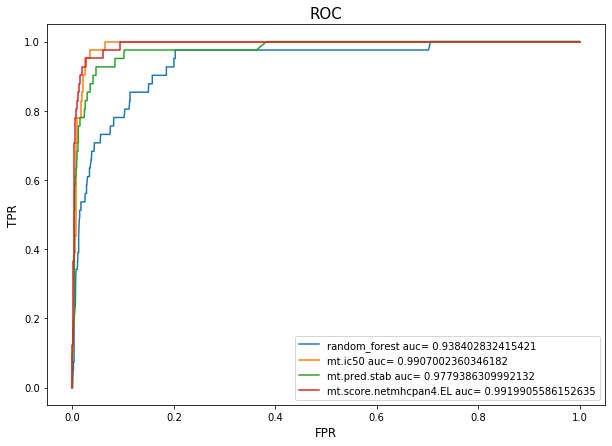

In [17]:
plt.figure(figsize=(10,7))
draw_roc(data_rf, 'random_forest')
draw_roc(data_others, 'mt.ic50')
draw_roc(data_others, 'mt.pred.stab')
draw_roc(data_others, 'mt.score.netmhcpan4.EL')
plt.legend()
plt.xlabel('FPR', fontsize = 12)
plt.ylabel('TPR', fontsize = 12)
plt.title('ROC',fontsize='15')

### Prec1%

In [27]:
SIZE = int(len(data_rf))
print(SIZE)

1591


In [29]:
def prec1(data, feature):
    '''
    get top %1 precision
    
    data = dataframe
    feature = a column of the dataframe
    
    '''
    data_sampled = data[['classification',feature]]
    if np.mean(data_sampled[data_sampled['classification']=='positive'][feature]) < np.mean(data_sampled[feature]):
        data_sampled[feature] = -data_sampled[feature]
    
    data_sampled.sort_values(by = [feature], inplace = True, ascending = False)
    topdata = data_sampled[:int(SIZE/100)]
    #return data_sampled
    return float(len(topdata[topdata['classification'] == 'positive']))/(float(SIZE)/100)

In [30]:
result = [prec1(data_rf, 'random_forest'), prec1(data_others, 'mt.ic50'), 
          prec1(data_others, 'mt.pred.stab'), prec1(data_others, 'mt.score.netmhcpan4.EL')]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'top %1 precision')

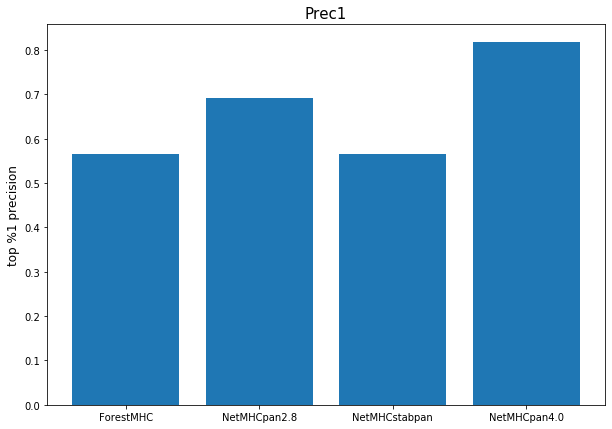

In [31]:
plt.figure(figsize=(10,7))
plt.bar(['ForestMHC', 'NetMHCpan2.8', 'NetMHCstabpan', 'NetMHCpan4.0'], result)
plt.title('Prec1', fontsize = 15)
plt.ylabel('top %1 precision', fontsize = 12)

其他三个工具的结果比文章高很多，但是 ForestMHC 基本达到文章展示的效果（文章 ForestMHC 在未见过的数据集里 prec1% 将近 0.6）。

原文用 MS 识别 534 条数据，并用 1:99 的比例加入 decoys，共 53400。进行 5 次，每次使用不同的 decoys。

prec1 展现的结果说明，在限制估计是 positive 的样本数目的情况下，精确度能够达到文章展示的不错的 PPV。但是文章的 positive labels 有 538 个，这个数据集只有 16 个左右。

### prec2.5%

In [33]:
def prec25(data, feature):
    '''
    get top %1 precision
    
    data = dataframe
    feature = a column of the dataframe
    
    '''
    data_sampled = data[['classification',feature]]
    if np.mean(data_sampled[data_sampled['classification']=='positive'][feature]) < np.mean(data_sampled[feature]):
        data_sampled[feature] = -data_sampled[feature]
    
    data_sampled.sort_values(by = [feature], inplace = True, ascending = False)
    topdata = data_sampled[:int(SIZE * 0.025)]
    #return data_sampled
    return float(len(topdata[topdata['classification'] == 'positive']))/(float(SIZE) * 0.025)

In [34]:
result = [prec25(data_rf, 'random_forest'), prec25(data_others, 'mt.ic50'), 
          prec25(data_others, 'mt.pred.stab'), prec25(data_others, 'mt.score.netmhcpan4.EL')]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'top %2.5 precision')

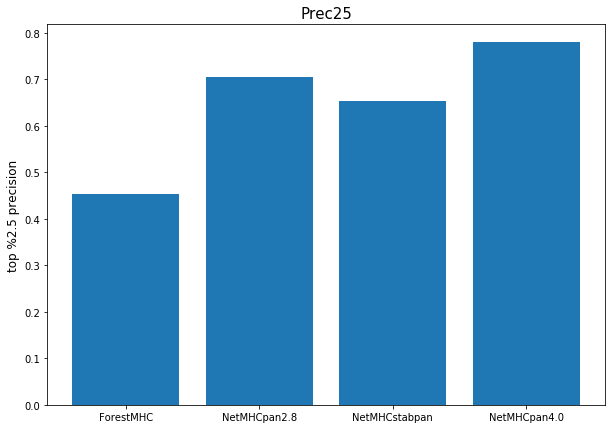

In [36]:
plt.figure(figsize=(10,7))
plt.bar(['ForestMHC', 'NetMHCpan2.8', 'NetMHCstabpan', 'NetMHCpan4.0'], result)
plt.title('Prec25', fontsize = 15)
plt.ylabel('top %2.5 precision', fontsize = 12)

### AUPRC

In [22]:
def draw_prc(data, feature):
    '''
    draw prc
    
    data = dataframe
    feature = a column of the dataframe
    
    '''   
    lab, score = roc(data, feature)
    auprc_score = skm.average_precision_score(lab, score)
    precision, recall = skm.precision_recall_curve(lab, score)[:2]
    plt.plot(recall, precision, label = feature + ' auprc= ' + str(auprc_score))
    
    return True

Text(0.5, 1.0, 'PRC')

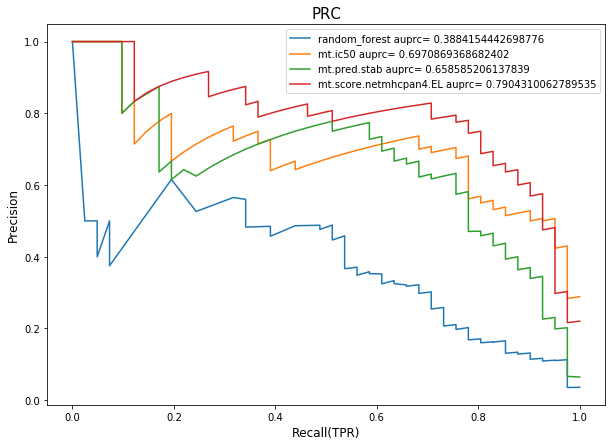

In [23]:
plt.figure(figsize=(10,7))
draw_prc(data_rf, 'random_forest')
draw_prc(data_others, 'mt.ic50')
draw_prc(data_others, 'mt.pred.stab')
draw_prc(data_others, 'mt.score.netmhcpan4.EL')
plt.legend()
plt.xlabel('Recall(TPR)', fontsize = 12)
plt.ylabel('Precision', fontsize = 12)
plt.title('PRC',fontsize='15')

与上一个图结合来看，虽然在控制 TP + FP 的情况下，PPV 可以很高（FP 低），但是上图显示，如果需要大比例捕获 positive 样本，则会伴随 precision 丢失（相比其他三个工具在这个数据集上的表现）。也就是说，这个工具在这个数据集上展现的覆盖正例的能力较差。

### correlation with IC50

In [24]:
data_ic50 = data_others[['mt.pep','classification','mt.ic50']].copy()

In [25]:
data_ic50['random_forest'] = np.nan

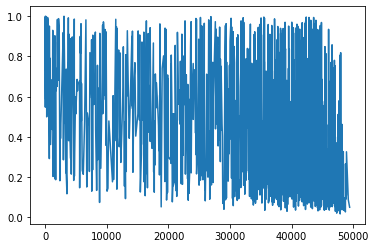

In [26]:
for i in data_ic50.index:
    data_ic50.loc[i, 'random_forest'] = pep_dict[data_ic50.loc[i, 'mt.pep']]
plt.plot(sorted(data_ic50['mt.ic50']), np.array(data_ic50['random_forest'])[np.argsort(data_ic50['mt.ic50'])])

在这个数据集中和 NetMHCpan2.8 的 IC50 基本上没有看出协同性。